In [1]:

import pandas as pd
from sklearn.cluster import KMeans

In [2]:
axa = pd.read_csv("axa-output-1-to-71")
allianz = pd.read_csv("allianz-1-to-94")
camca = pd.read_csv("camca-output-1-to-49")
covea = pd.read_csv("covea-output-1-to-98")

axa_copy = pd.read_csv("axa-output-1-to-71")
allianz_copy = pd.read_csv("allianz-1-to-94")
camca_copy = pd.read_csv("camca-output-1-to-49")
covea_copy = pd.read_csv("covea-output-1-to-98")

l = {'axa': axa_copy, 'allianz': allianz_copy, 'camca': camca_copy, 'covea': covea_copy}

In [3]:
axa.columns

Index(['Unnamed: 0', 'num_page', 'text', 'width', 'height', 'area', 'chars',
       'char_size', 'pos_x', 'pos_y', 'aspect', 'layout', 'x0', 'x1', 'y0',
       'y1', 'assureur'],
      dtype='object')

In [26]:
axa


,Unnamed: 0,num_page,text,width,height,area,chars,char_size,pos_x,pos_y,aspect,layout,x0,x1,y0,y1,assureur
0,0,1,AA,0.104202,0.035672,0.003717,3,0.001239,0.142857,0.115339,2.921121,h,0.090756,0.194958,0.097503,0.098692,axa-output-1-to-71
1,1,1,AXA SA,0.247059,0.035672,0.008813,7,0.001259,0.568908,0.366231,6.925887,h,0.445378,0.692437,0.348395,0.348395,axa-output-1-to-71
2,2,1,Rapport,0.213445,0.034483,0.007360,8,0.000920,0.415966,0.469084,6.189918,h,0.309244,0.522689,0.451843,0.451843,axa-output-1-to-71
3,3,1,sur la Solvabilité,0.443698,0.036861,0.016355,19,0.000861,0.452101,0.522592,12.037077,h,0.230252,0.673950,0.507729,0.504162,axa-output-1-to-71
4,4,1,et la Situation Financière,0.667227,0.030916,0.020628,27,0.000764,0.479832,0.585018,21.582243,h,0.146219,0.813445,0.569560,0.569560,axa-output-1-to-71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1932,1932,71,État S.23.01.02 Fonds propres,0.173109,0.010702,0.001853,30,0.000062,0.237815,0.532105,16.176016,h,0.151261,0.324370,0.526754,0.529132,axa-output-1-to-71
1933,1933,71,État S.25.01.01 Capital de solvabilité requis ...,0.490756,0.009513,0.004668,88,0.000053,0.396639,0.554102,51.590674,h,0.151261,0.642017,0.549346,0.549346,axa-output-1-to-71
1934,1934,71,État S.28.01.01 Minimum de capital requis act...,0.717647,0.024970,0.017920,162,0.000111,0.510084,0.582045,28.740038,h,0.151261,0.868908,0.569560,0.570749,axa-output-1-to-71
1935,1935,71,71,0.016807,0.008323,0.000140,3,0.000047,0.497479,0.938763,2.019210,h,0.489076,0.505882,0.934602,0.934602,axa-output-1-to-71


# Après avoir ouvert les CV dans un Excel, et compris le fonctionnement de chaque features, je remarque que beaucoup de texte n'ont pas de sens, comme les N/A, les chiffres des tableaux, et beaucoup de texte répétitif. J'ai jugé que commencer par traiter les données à ce moment ajoute beaucoup de bruit à l'analyse.

## J'ai commencé donc par éliminer les cas les plus flagrants. Le layout permet de savoir si le texte est 'h' = horizontal ou 'v' = vertical. On peut donc éliminer toutes les lignes dont layout = 'v'

In [7]:
def filter_layout(nom ,df):
    removed_rows = df[df['layout'] == 'v']
    removed_rows.to_csv(f"../removed/{nom}_removed_rows_filter_layout.csv", index=False)
    df = df.drop(removed_rows.index)
    return ()

In [3]:
for name, df in l.items():
    removed_rows = df[df['layout'] == 'v']
    # removed_rows.to_csv(f"../removed/{name}_removed_rows_filter_layout.csv", index=False)
    l[name] = df.drop(removed_rows.index).copy()


## Effectuons une analyse des occurrences des textes. Les titres ainsi que les hauts de page et les bas de page doivent apparaître un certain nombre de fois. Commençons par éliminer les plus récurrents

In [5]:
for name, df in l.items():
    occurence_texte = df['text'].value_counts()
    occurence_texte.to_csv(f"../removed/{name}_occ.csv")

On peut voir dans tous les rapports que le titre apparaissant avec le plus d'occurrence est "Activité et résultats" dans le rapport d'Allianz avec 9 occurrences, du fait que ce titre apparaît aussi en haut de page. On va donc filtrer tous les textes dont l'occurrence dépasse 10 pour conserver tous les titres dans le traitement.

In [9]:
def filtrer_les_occurences (name ,df):
    occurence_texte = df['text'].value_counts()
    occurence_texte[occurence_texte >= 10].to_csv(f"../removed/{name}_occ_filter.csv")
    l[name] = df[df['text'].isin(occurence_texte[occurence_texte < 10].index)]

In [4]:
for name, df in l.items():
    occurence_texte = df['text'].value_counts()
    # occurence_texte[occurence_texte >= 10].to_csv(f"../removed/Occurrence_filtre/{name}_occ_filter.csv")
    l[name] = df[df['text'].isin(occurence_texte[occurence_texte < 10].index)]

## On peut voir après que parmis les autres plus grande occurance il y a beaucoup de texte contenant des chiffres. On va donc filtrer tout les textes conenant que des chiffres qui seront ni des titres ni des paragraphes

In [5]:
for name, df in l.items():
    indices_a_supprimer = pd.to_numeric(df['text'], errors='coerce', downcast='integer').notna()
    # df[indices_a_supprimer].to_csv(f"../removed/num_filtre/{name}_num_filter.csv")
    l[name] = df[~indices_a_supprimer]

In [6]:
for name, df in l.items():
    df.to_csv(f"../removed/{name}_reste_après_filtre.csv")

L'ensemble des lignes filtrées ici vont être concatenées plus tard avec le reste des données et labélisées en inutile. 

# Utilisation de l'ACP pour facilité le clustering

In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
l_scale = {key: df[['width', 'height', 'area', 'chars',
       'char_size', 'pos_x', 'pos_y', 'aspect', 'x0', 'x1', 'y0',
       'y1']].copy() for key, df in l.items()}

In [8]:
for name, df in l_scale.items():
    scaler=StandardScaler()
    scaler.fit(df)
    l_scale[name]=scaler.transform(df)

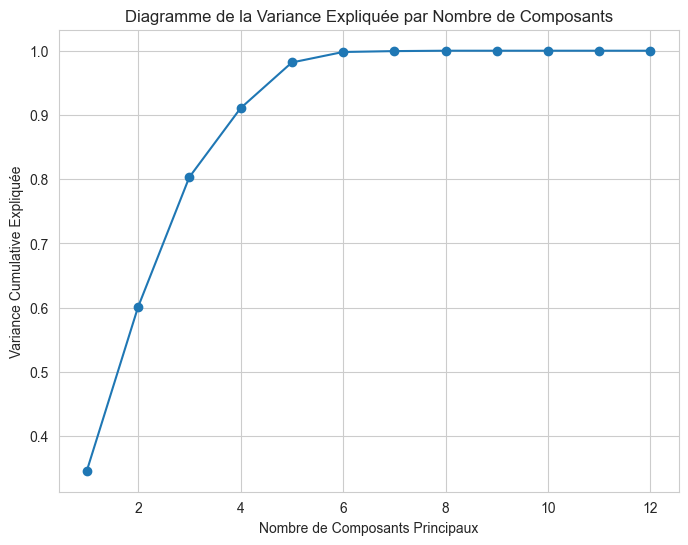

In [11]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

df = l_scale["axa"]
# Instancier l'objet PCA sans préciser le nombre de composants pour tous les calculer
pca = PCA()
pca.fit(df)  # 'df' est votre DataFrame avec les données

# Variance expliquée par chaque composant
explained_variance_ratio = pca.explained_variance_ratio_

# Tracé du diagramme
plt.figure(figsize=(8, 6))
plt.plot(
    np.arange(1, len(explained_variance_ratio) + 1),
    np.cumsum(explained_variance_ratio),
    marker='o', linestyle='-'
)
plt.xlabel('Nombre de Composants Principaux')
plt.ylabel('Variance Cumulative Expliquée')
plt.title('Diagramme de la Variance Expliquée par Nombre de Composants')
plt.grid(True)
plt.show()


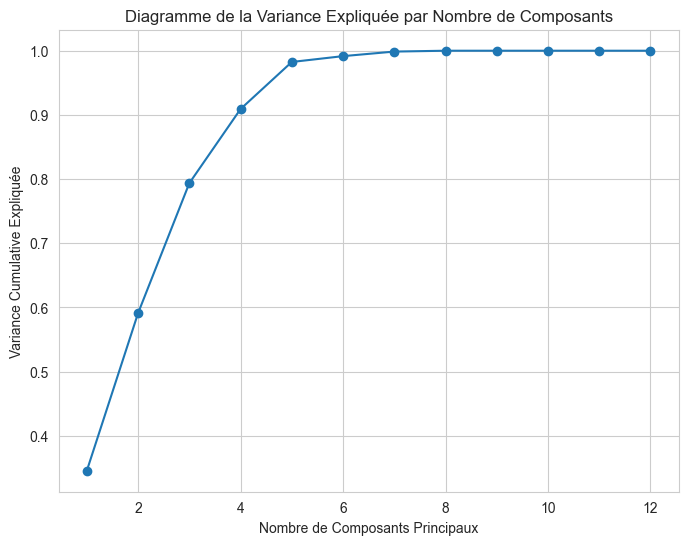

In [12]:
df = l_scale["allianz"]
# Instancier l'objet PCA sans préciser le nombre de composants pour tous les calculer
pca = PCA()
pca.fit(df)  # 'df' est votre DataFrame avec les données

# Variance expliquée par chaque composant
explained_variance_ratio = pca.explained_variance_ratio_

# Tracé du diagramme
plt.figure(figsize=(8, 6))
plt.plot(
    np.arange(1, len(explained_variance_ratio) + 1),
    np.cumsum(explained_variance_ratio),
    marker='o', linestyle='-'
)
plt.xlabel('Nombre de Composants Principaux')
plt.ylabel('Variance Cumulative Expliquée')
plt.title('Diagramme de la Variance Expliquée par Nombre de Composants')
plt.grid(True)
plt.show()


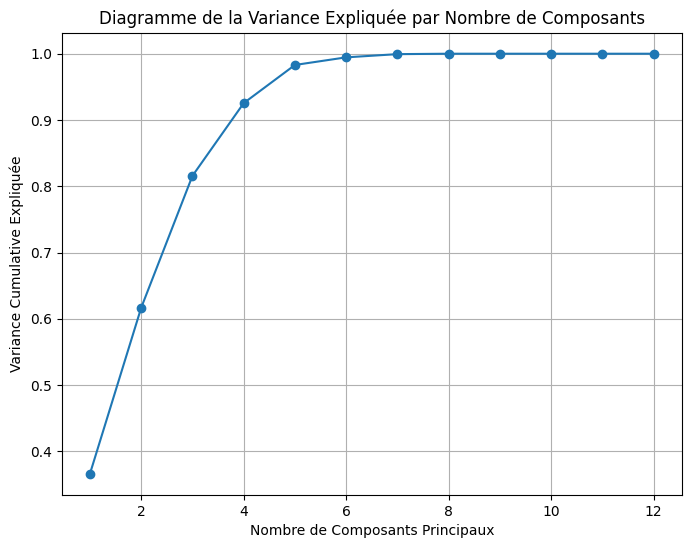

In [18]:
df = l_scale["covea"]
# Instancier l'objet PCA sans préciser le nombre de composants pour tous les calculer
pca = PCA()
pca.fit(df)  # 'df' est votre DataFrame avec les données

# Variance expliquée par chaque composant
explained_variance_ratio = pca.explained_variance_ratio_

# Tracé du diagramme
plt.figure(figsize=(8, 6))
plt.plot(
    np.arange(1, len(explained_variance_ratio) + 1),
    np.cumsum(explained_variance_ratio),
    marker='o', linestyle='-'
)
plt.xlabel('Nombre de Composants Principaux')
plt.ylabel('Variance Cumulative Expliquée')
plt.title('Diagramme de la Variance Expliquée par Nombre de Composants')
plt.grid(True)
plt.show()


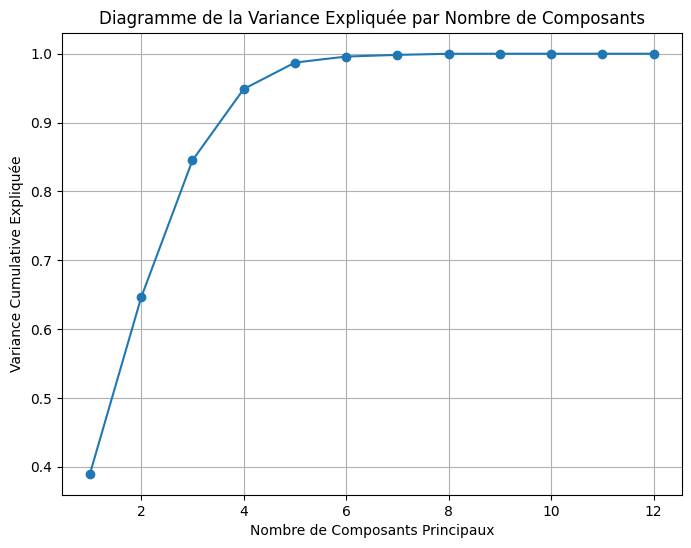

In [19]:
df = l_scale["camca"]
# Instancier l'objet PCA sans préciser le nombre de composants pour tous les calculer
pca = PCA()
pca.fit(df)  # 'df' est votre DataFrame avec les données

# Variance expliquée par chaque composant
explained_variance_ratio = pca.explained_variance_ratio_

# Tracé du diagramme
plt.figure(figsize=(8, 6))
plt.plot(
    np.arange(1, len(explained_variance_ratio) + 1),
    np.cumsum(explained_variance_ratio),
    marker='o', linestyle='-'
)
plt.xlabel('Nombre de Composants Principaux')
plt.ylabel('Variance Cumulative Expliquée')
plt.title('Diagramme de la Variance Expliquée par Nombre de Composants')
plt.grid(True)
plt.show()


Pour déterminer le nombre optimal de composantes principales à conserver, nous avons tracé le diagramme de la variance expliquée en fonction du nombre de composantes. Ce graphique met en évidence la proportion de la variance totale capturée par chaque composante principale. En observant la courbe, nous avons identifié un point d'inflexion clair après la cinquième composante, indiquant que l'ajout de composantes supplémentaires n'apporte qu'une amélioration marginale à la variance expliquée. Ainsi, en retenant les 5 premières composantes principales, nous maximisons la représentativité des données tout en réduisant leur dimensionnalité, ce qui garantit une efficacité accrue pour les analyses suivantes sans perte significative d'information.

## Appliquons le k-means en utilisant les 5 premières composantes principales issues de l'ACP pour maximiser la variance expliquée.

In [23]:
from sklearn.decomposition import PCA

In [21]:

l_acp = dict.fromkeys(['axa', 'allianz', 'camca', 'covea'])

for name, df in l_scale.items():
    pca = PCA(5)
    l_acp[name]=pca.fit_transform(df)
    # loadings = pd.DataFrame(pca.components_, columns=noms_colonnes,
    #                         index=[f"PC{i + 1}" for i in range(pca.n_components_)])
    # print(loadings)

        width    height      area     chars  char_size     pos_x     pos_y  \
PC1  0.424225  0.452207  0.469601  0.456472   0.157082  0.096835  0.003827   
PC2 -0.021210  0.011096 -0.010757 -0.025143   0.143469 -0.088445 -0.565911   
PC3 -0.166397  0.056622  0.036207  0.038896  -0.166300  0.580753 -0.070027   
PC4 -0.322652  0.304891  0.231341  0.257687  -0.159120 -0.301776  0.045881   
PC5 -0.051184  0.017988 -0.052612 -0.165313   0.923064  0.038420  0.082576   

       aspect        x0        x1        y0        y1  
PC1  0.061780 -0.195323  0.331046 -0.022643 -0.022611  
PC2 -0.026675 -0.057516 -0.079975 -0.565509 -0.565510  
PC3 -0.374411  0.574598  0.339596 -0.073415 -0.073400  
PC4 -0.617429 -0.035027 -0.424869  0.028018  0.027896  
PC5 -0.298456  0.063934 -0.001963  0.081946  0.082066  
        width    height      area     chars  char_size     pos_x     pos_y  \
PC1  0.448147  0.365879  0.442398  0.435995   0.079642 -0.103436  0.167523   
PC2  0.096770  0.180656  0.167307  0.14

In [33]:
# Variance expliquée par chaque composante principale
explained_variance_ratio = pca.explained_variance_ratio_

# Variance cumulée
cumulative_variance = explained_variance_ratio.cumsum()

print("Variance expliquée par les 5 composantes :", explained_variance_ratio)
print("Variance cumulée après 5 composantes :", cumulative_variance[-1])


Variance expliquée par les 5 composantes : [0.36618877 0.25045663 0.19904127 0.10972051 0.0576131 ]
Variance cumulée après 5 composantes : 0.9830202744562797


In [22]:
centroids = dict.fromkeys(['axa', 'allianz', 'camca', 'covea'])
columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5']

def k_means (df_acp, name):

    kmeans_model = KMeans(n_clusters=3)
    l[name]['label'] = kmeans_model.fit_predict(df_acp)

    centroid_df = pd.DataFrame(kmeans_model.cluster_centers_, columns=columns)
    variances = centroid_df.var()
    most_separating_component = variances.idxmax()
    # print(name,most_separating_component)
    centroid_values = centroid_df[most_separating_component].values

    # Étape 2 : Trier les clusters selon cette composante
    sorted_indices = np.argsort(centroid_values)  # Ordre croissant des centroïdes
    reassignment_map = {old: new for new, old in enumerate(sorted_indices)}
    centroids[name] = centroid_df
    l[name]['label'] = l[name]['label'].map(reassignment_map)
    return

for name, df_acp in l_acp.items():
    k_means(df_acp,name)
    # l[name].to_csv(f"../data/labeled_avec_acp/{name}_label.csv")

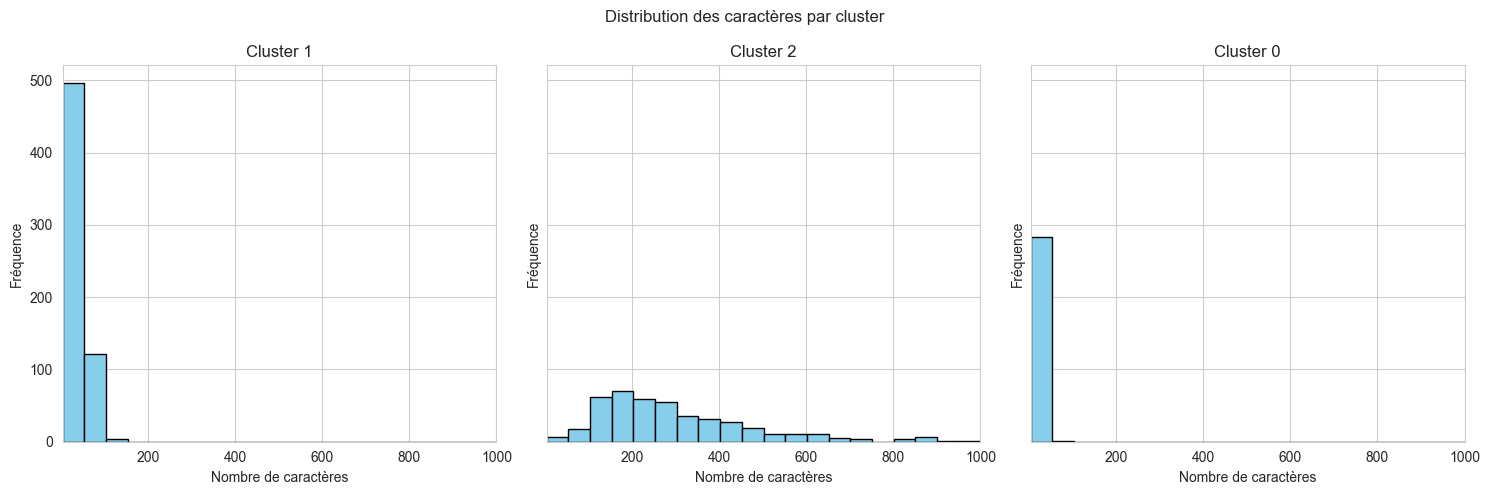

In [56]:
import matplotlib.pyplot as plt


df = l["axa"]
# Définir la plage commune des valeurs de `chars` pour l'échelle des histogrammes
min_chars = df['chars'].min()
max_chars = 1000

# Nombre de clusters
clusters = df['label'].unique()
n_clusters = len(clusters)

# Créer les sous-graphes pour chaque cluster
fig, axes = plt.subplots(1, n_clusters, figsize=(5 * n_clusters, 5), sharey=True)

for i, cluster in enumerate(clusters):
    ax = axes[i]
    subset = df[df['label'] == cluster]

    ax.hist(subset['chars'], bins=20, range=(min_chars, max_chars), color='skyblue', edgecolor='black')
    ax.set_title(f"Cluster {cluster}")
    ax.set_xlabel("Nombre de caractères")
    ax.set_ylabel("Fréquence")
    ax.set_xlim(min_chars, max_chars)  # Échelle commune pour l'axe x

plt.suptitle("Distribution des caractères par cluster")
plt.tight_layout()
plt.show()


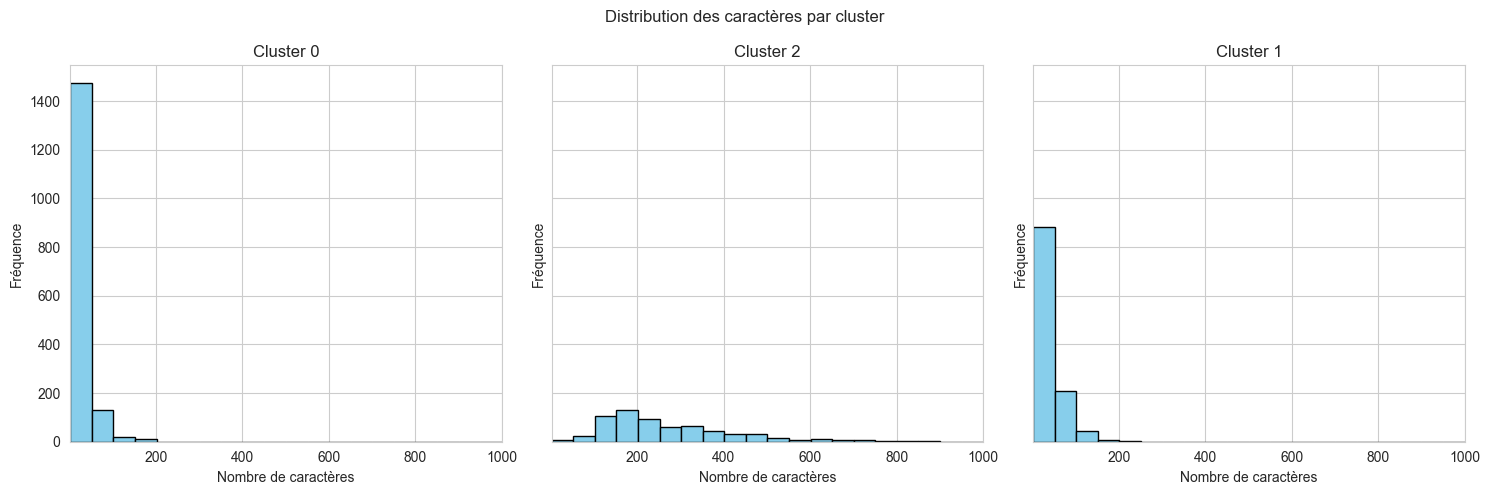

In [57]:
import matplotlib.pyplot as plt


df = l["allianz"]
# Définir la plage commune des valeurs de `chars` pour l'échelle des histogrammes
min_chars = df['chars'].min()
max_chars = 1000

# Nombre de clusters
clusters = df['label'].unique()
n_clusters = len(clusters)

# Créer les sous-graphes pour chaque cluster
fig, axes = plt.subplots(1, n_clusters, figsize=(5 * n_clusters, 5), sharey=True)

for i, cluster in enumerate(clusters):
    ax = axes[i]
    subset = df[df['label'] == cluster]

    ax.hist(subset['chars'], bins=20, range=(min_chars, max_chars), color='skyblue', edgecolor='black')
    ax.set_title(f"Cluster {cluster}")
    ax.set_xlabel("Nombre de caractères")
    ax.set_ylabel("Fréquence")
    ax.set_xlim(min_chars, max_chars)  # Échelle commune pour l'axe x

plt.suptitle("Distribution des caractères par cluster")
plt.tight_layout()
plt.show()


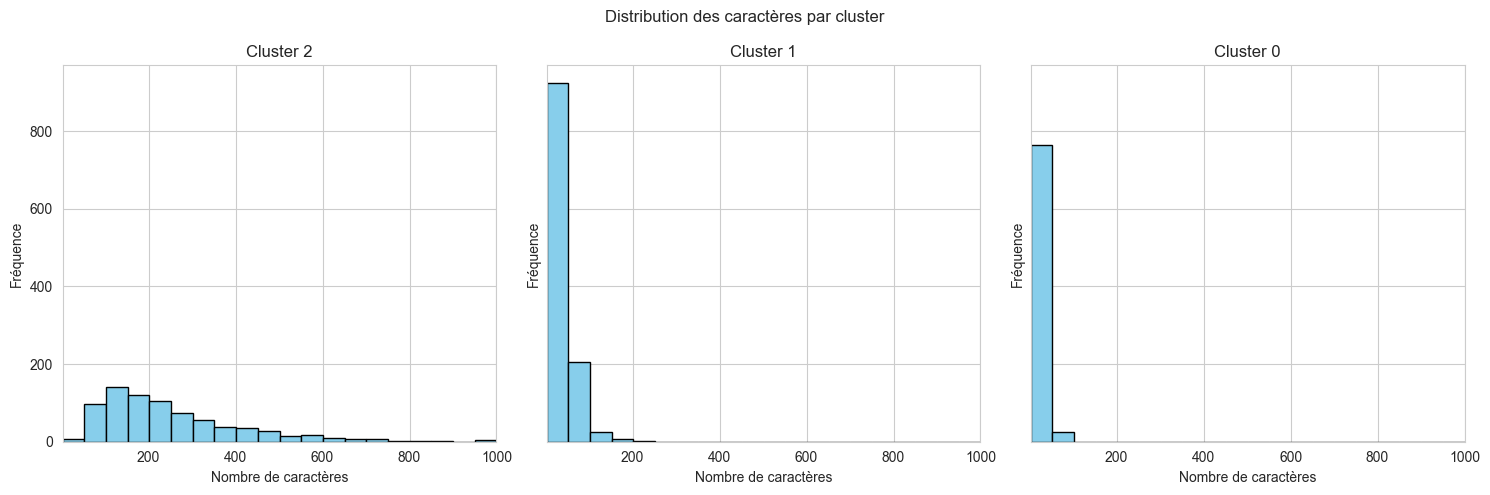

In [58]:
import matplotlib.pyplot as plt


df = l["covea"]
# Définir la plage commune des valeurs de `chars` pour l'échelle des histogrammes
min_chars = df['chars'].min()
max_chars = 1000

# Nombre de clusters
clusters = df['label'].unique()
n_clusters = len(clusters)

# Créer les sous-graphes pour chaque cluster
fig, axes = plt.subplots(1, n_clusters, figsize=(5 * n_clusters, 5), sharey=True)

for i, cluster in enumerate(clusters):
    ax = axes[i]
    subset = df[df['label'] == cluster]

    ax.hist(subset['chars'], bins=20, range=(min_chars, max_chars), color='skyblue', edgecolor='black')
    ax.set_title(f"Cluster {cluster}")
    ax.set_xlabel("Nombre de caractères")
    ax.set_ylabel("Fréquence")
    ax.set_xlim(min_chars, max_chars)  # Échelle commune pour l'axe x

plt.suptitle("Distribution des caractères par cluster")
plt.tight_layout()
plt.show()


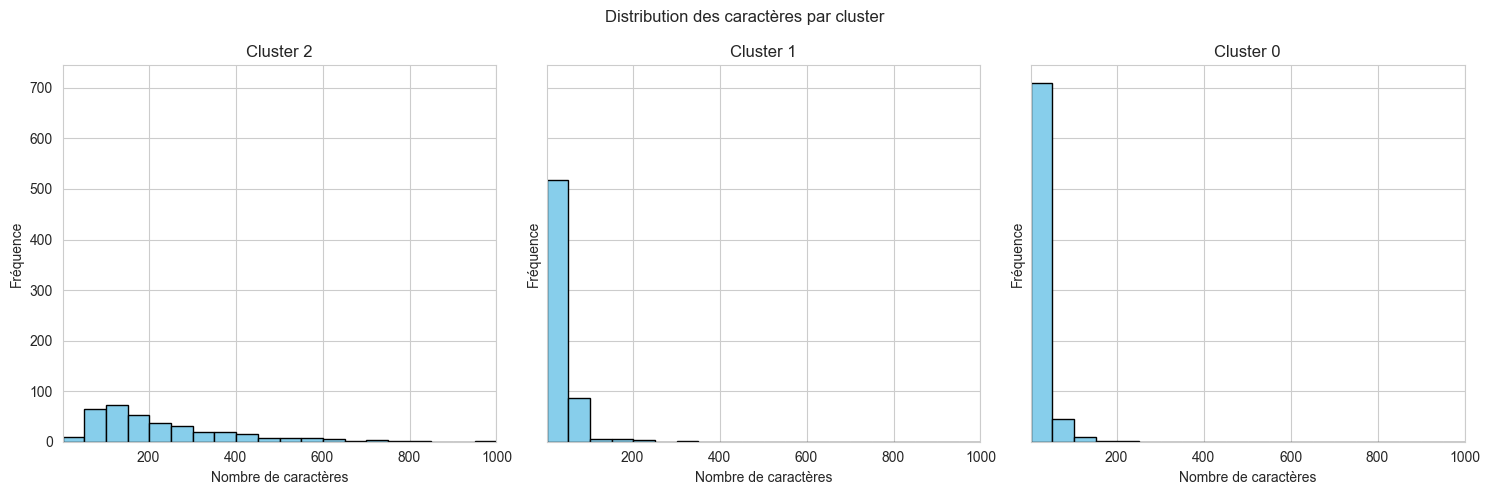

In [59]:
import matplotlib.pyplot as plt


df = l["camca"]
# Définir la plage commune des valeurs de `chars` pour l'échelle des histogrammes
min_chars = df['chars'].min()
max_chars = 1000

# Nombre de clusters
clusters = df['label'].unique()
n_clusters = len(clusters)

# Créer les sous-graphes pour chaque cluster
fig, axes = plt.subplots(1, n_clusters, figsize=(5 * n_clusters, 5), sharey=True)

for i, cluster in enumerate(clusters):
    ax = axes[i]
    subset = df[df['label'] == cluster]

    ax.hist(subset['chars'], bins=20, range=(min_chars, max_chars), color='skyblue', edgecolor='black')
    ax.set_title(f"Cluster {cluster}")
    ax.set_xlabel("Nombre de caractères")
    ax.set_ylabel("Fréquence")
    ax.set_xlim(min_chars, max_chars)  # Échelle commune pour l'axe x

plt.suptitle("Distribution des caractères par cluster")
plt.tight_layout()
plt.show()


En analysant la répartition du nombre de caractères au sein de chaque cluster, nous pouvons évaluer la pertinence de la segmentation effectuée. Une distribution cohérente et distincte entre les clusters indique que les regroupements reflètent efficacement des catégories de contenu textuel ayant des caractéristiques similaires, telles que les titres, les paragraphes ou les contenus inutiles. Par exemple, le cluster 2 contient de nombreuses lignes avec un grand nombre de caractères, ce qui suggère qu’il correspond aux paragraphes, généralement des blocs de texte denses et riches en contenu. La prédominance de ces lignes longues dans ce cluster montre une segmentation alignée avec la structure attendue des rapports.

De même, le cluster 0 regroupe un grand nombre de lignes avec peu de caractères, ce qui laisse penser qu’il contient principalement des textes inutiles, tels que des bas de page ou des annotations sans valeur ajoutée.

Enfin, le cluster 1 semble correspondre aux titres. Bien qu'il présente des similarités avec le cluster 0, il s'en distingue par des lignes courtes, souvent composées d’un seul mot (par exemple, "Activité") ou d’un court groupe nominal (comme "Système de gestion des risques, y compris l’évaluation interne des risques et de la solvabilité").

Cette différenciation claire entre les clusters montre que la méthodologie de clustering a efficacement capturé la structure sous-jacente des blocs textuels. Bien que certaines lignes soient mal catégorisées, les résultats confirment globalement la robustesse de notre approche.

